**IMPORTS**

In [1]:
import numpy as np
from PIL import Image
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import os
import csv
import random
#model

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, ZeroPadding2D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split


#hyperparameters
IMAGE_SIZE = 64
LABELS = 15
MULTILABEL = True

#potentially tunable hyperparameters
EPOCHS = 100
BATCH_SIZE = 20

Using TensorFlow backend.


**LOAD DATA**

In [2]:
#load the data into a dictionary
# This serves as an additional test that the data
# can be loaded all at once

#folders_to_load = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
total_files2 = []

folder = "Resized_{}".format(IMAGE_SIZE)
  
total_files = os.listdir(folder)
for i in total_files:
    if ".png" in i:
        total_files2.append(i)

total_files = total_files2

print("{} Images Found.".format(len(total_files)))

#build y dict beforehand, do conversions on the fly
#now build y_dict
name_to_ylabels = {}
name_to_zlabels = {}
with open("Data_Entry_2017.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are ' + ", ".join(row))
        else:
            name_to_ylabels[row[0]] = row[1]
            #for z data, we want 4,5
            #bit of fancy formatting, age is /100, gender is flag
            
            age = 1.0*int(row[4])/100
            gender = 1.0*(row[5] == "M")
            name_to_zlabels[row[0]] = [age, gender]
        line_count+=1
        

        
#build table for y_encoding
y_fake = []
for i in name_to_ylabels.keys():
    y_fake.append(name_to_ylabels[i].split("|")[0])

le = LabelEncoder()
le.fit(y_fake)

#now load the data 
x_dict = {}
y_dict = {}
z_dict = {}

x = 0
for i in total_files:
    image = Image.open(folder+"/"+i)
    x_dict[i] = np.asarray(image)
    
    y_label = [0]*LABELS
    for descriptor in name_to_ylabels[i].split("|"):
        y_label[le.transform([descriptor])[0]] = 1
        
        
    y_dict[i] = y_label
    z_dict[i] = name_to_zlabels[i]
    
    if x % 10000 == 9999:
        print("{} images loaded".format(x+1))
    x+=1

#clear old dicts
name_to_ylabels.clear()
name_to_zlabels.clear()

print("All images loaded")





103120 Images Found.
Column names are Image Index, Finding Labels, Follow-up #, Patient ID, Patient Age, Patient Gender, View Position, OriginalImage[Width, Height], OriginalImagePixelSpacing[x, y], 
10000 images loaded
20000 images loaded
30000 images loaded
40000 images loaded
50000 images loaded
60000 images loaded
70000 images loaded
80000 images loaded
90000 images loaded
100000 images loaded
All images loaded


**PREP DATA**

In [3]:
#In this step we move the data into a format usable by our model and then 

#This should probably be redone later to further clean

x_data = []
y_data = []
z_data = []

#as we loop through files, clean data in place - save memory
for i in total_files:
    x_data.append(x_dict[i])
    y_data.append(y_dict[i])
    z_data.append(z_dict[i])
    del x_dict[i]
    del y_dict[i]
    del z_dict[i]

#and wipe dict
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)
z_data = np.asarray(z_data)
x_dict.clear()
y_dict.clear()
z_dict.clear()


**VISUALIZE DATA**

Data size
x_data: (103120, 64, 64)
y_data: (103120, 15)
z_data: (103120, 2)


Sample Images:


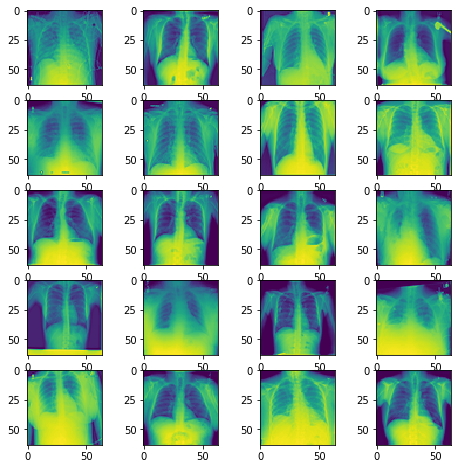

Illness Histograms:


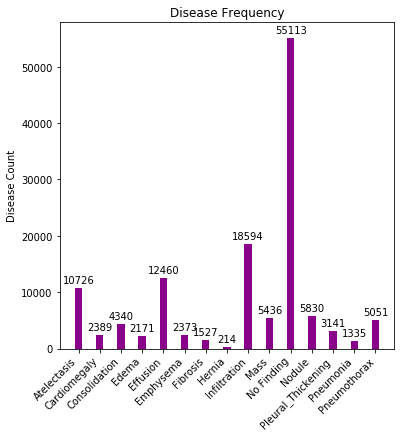

In [4]:
#This stage is for data exploration - look for outliers and general shape of the data

print("Data size")
print("x_data: {}".format(x_data.shape))
print("y_data: {}".format(y_data.shape))
print("z_data: {}".format(z_data.shape))

#First analysis: means of data
fig = plt.figure(figsize=(8,8))
columns = 4
rows = 5
print("\n\nSample Images:")
for i in range(1, columns*rows +1):
    img = random.choice(x_data)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

#build some age - illness data

age_to_disease = {}
gender_to_disease = {}
disease_frequency = [0]*15


for i in range(len(y_data)):
    disease_frequency = [disease_frequency[j] + y_data[i][j] for j in range(len(y_data[i]))]
    


print("Illness Histograms:")

#helper function from matplotlib.org
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


labels = [le.inverse_transform([i])[0] for i in range(LABELS)]

x = np.arange(len(labels))
width = .35

fig, ax = plt.subplots()
rects1 = ax.bar(x, disease_frequency, width, color="darkmagenta")
ax.set_ylabel("Disease Count")
ax.set_title("Disease Frequency")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xticks(rotation=45, ha="right")
autolabel(rects1)
fig.set_figheight(6)

#fig.tight_layout()
plt.show()



**BUILD MODEL**

In [5]:
#My first test model is going to be vgg-16 for 15 classes multi-label
# This means it will follow the general architecture, but end with a sigmoid

#The model will also factor in other user features through a secondary
# input feed
def build_model(model_type):
    #get metadata about input shape - may need to be fixed
    if model_type == "svg16":
        
        image_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
        z_input = Input(shape=(2,))
    
        #layer 0
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(64, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(x)
        x = Conv2D(64, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)

        #layer 1
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(128, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(x)
        x = Conv2D(128, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)

        #layer 2
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(256, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(256, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(256, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)


        #layer 3
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)

        #layer 4
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(512, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)

        #layer - 5, output layer

        #flatten out model and add z info
        x = Flatten()(x)
        combined = keras.layers.concatenate([x, z_input], axis=1)
        x = Dense(4096, activation="relu")(combined)
        x = Dropout(.5)(x)
        x = Dense(4096, activation="relu")(combined)
        x = Dropout(.5)(x)
        main_output = Dense(15, activation="sigmoid")(x)
        model = Model(inputs=[image_input, z_input], outputs=[main_output])
        return model
    
    #test 2 - build a very simple model to test - this runs, but slowly
    if model_type == "simple":
        image_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
        z_input = Input(shape=(2,))
    
        #layer 0
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(64, (3,3), activation="relu")(x)
        x = ZeroPadding2D((1,1))(x)
        x = Conv2D(64, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)
        
        #flatten and add output
        x = Flatten()(x)
        combined = keras.layers.concatenate([x, z_input], axis=1)
        x = Dense(1024, activation="relu")(combined)
        x = Dropout(.5)(x)
        x = Dense(1024, activation="relu")(combined)
        x = Dropout(.5)(x)
        main_output = Dense(15, activation="sigmoid")(x)
        model = Model(inputs=[image_input, z_input], outputs=[main_output])
        return model
    
    #test 2 - build a very simple model to test
    if model_type == "simpler":
        image_input = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))
        z_input = Input(shape=(2,))
    
        #layer 0
        x = ZeroPadding2D((1,1))(image_input)
        x = Conv2D(64, (3,3), activation="relu")(x)
        x = MaxPooling2D((2,2), strides=(2,2))(x)
        
        #flatten and add output
        x = Flatten()(x)
        combined = keras.layers.concatenate([x, z_input], axis=1)
        x = Dense(512, activation="relu")(combined)
        x = Dropout(.5)(x)
        main_output = Dense(15, activation="sigmoid")(x)
        model = Model(inputs=[image_input, z_input], outputs=[main_output])
        return model

In [6]:
model = build_model("simpler")

W0323 19:53:37.048879 4575548864 deprecation_wrapper.py:119] From /Users/huntermccoy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [7]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 66, 66, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   640         zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 64)   0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [8]:
#compile the model
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

#reshape data to fit
x_data = x_data.reshape(-1,IMAGE_SIZE,IMAGE_SIZE,1)
print(x_data.shape)


#indices = np.random.permutation(x.shape[0])

x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(x_data, y_data, z_data, test_size=.3)

W0323 19:53:37.164212 4575548864 deprecation.py:323] From /Users/huntermccoy/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(103120, 64, 64, 1)


In [9]:
model.fit([x_train,z_train], y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

W0323 19:53:38.218345 4575548864 deprecation_wrapper.py:119] From /Users/huntermccoy/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/100
72184/72184 [==============================] - 1026s 14ms/step - loss: 0.7444 - accuracy: 0.9145
Epoch 2/100
72184/72184 [==============================] - 1027s 14ms/step - loss: 0.2195 - accuracy: 0.9234
Epoch 3/100
72184/72184 [==============================] - 1142s 16ms/step - loss: 0.2148 - accuracy: 0.9245
Epoch 4/100
72184/72184 [==============================] - 1156s 16ms/step - loss: 0.2137 - accuracy: 0.9245
Epoch 5/100
72184/72184 [==============================] - 1091s 15ms/step - loss: 0.2132 - accuracy: 0.9247
Epoch 6/100
72184/72184 [==============================] - 1052s 15ms/step - loss: 0.2138 - accuracy: 0.9242
Epoch 7/100
47320/72184 [==================>...........] - ETA: 5:59 - loss: 0.2123 - accuracy: 0.9250

KeyboardInterrupt: 